In [2]:
!pip install lightgbm xgboost


   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.5 MB 1.1 MB/s eta 0:00:02
   ------ --------------------------------- 0.2/1.5 MB 2.8 MB/s eta 0:00:01
   ------------------- -------------------- 0.7/1.5 MB 5.6 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.5 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 6.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.4/150.0 MB 13.2 MB/s eta 0:00:12
   ---------------------------------------- 0.9/150.0 MB 10.9 MB/s eta 0:00:14
   ---------------------------------------- 1.1/150.0 MB 8.6 MB/s eta 0:00:18
   ---------------------------------------- 1.6/150.0 MB 9.2 MB/s eta 0:00:17
    --------------------------------------- 2.2/150.0 MB 9.9 MB/s eta 0:00:15
    --------------------------------------- 2.6/150.0 MB 9.1 MB/s eta 0:00:17
    ------

In [3]:
import lightgbm as lgb
import xgboost as xgb


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

import lightgbm as lgb
import xgboost as xgb

In [5]:
# 2. LOAD DATA
train_df = pd.read_csv("Titanic_train.csv")
test_df = pd.read_csv("Titanic_test.csv")

# Combine for easier preprocessing
data = pd.concat([train_df, test_df], sort=False)

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 132.9+ KB
None
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.020061    0

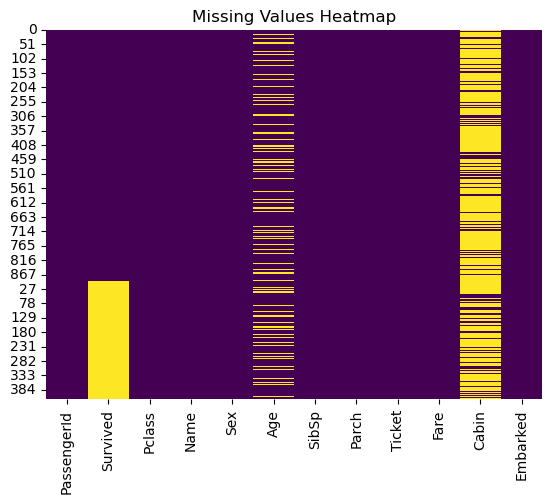

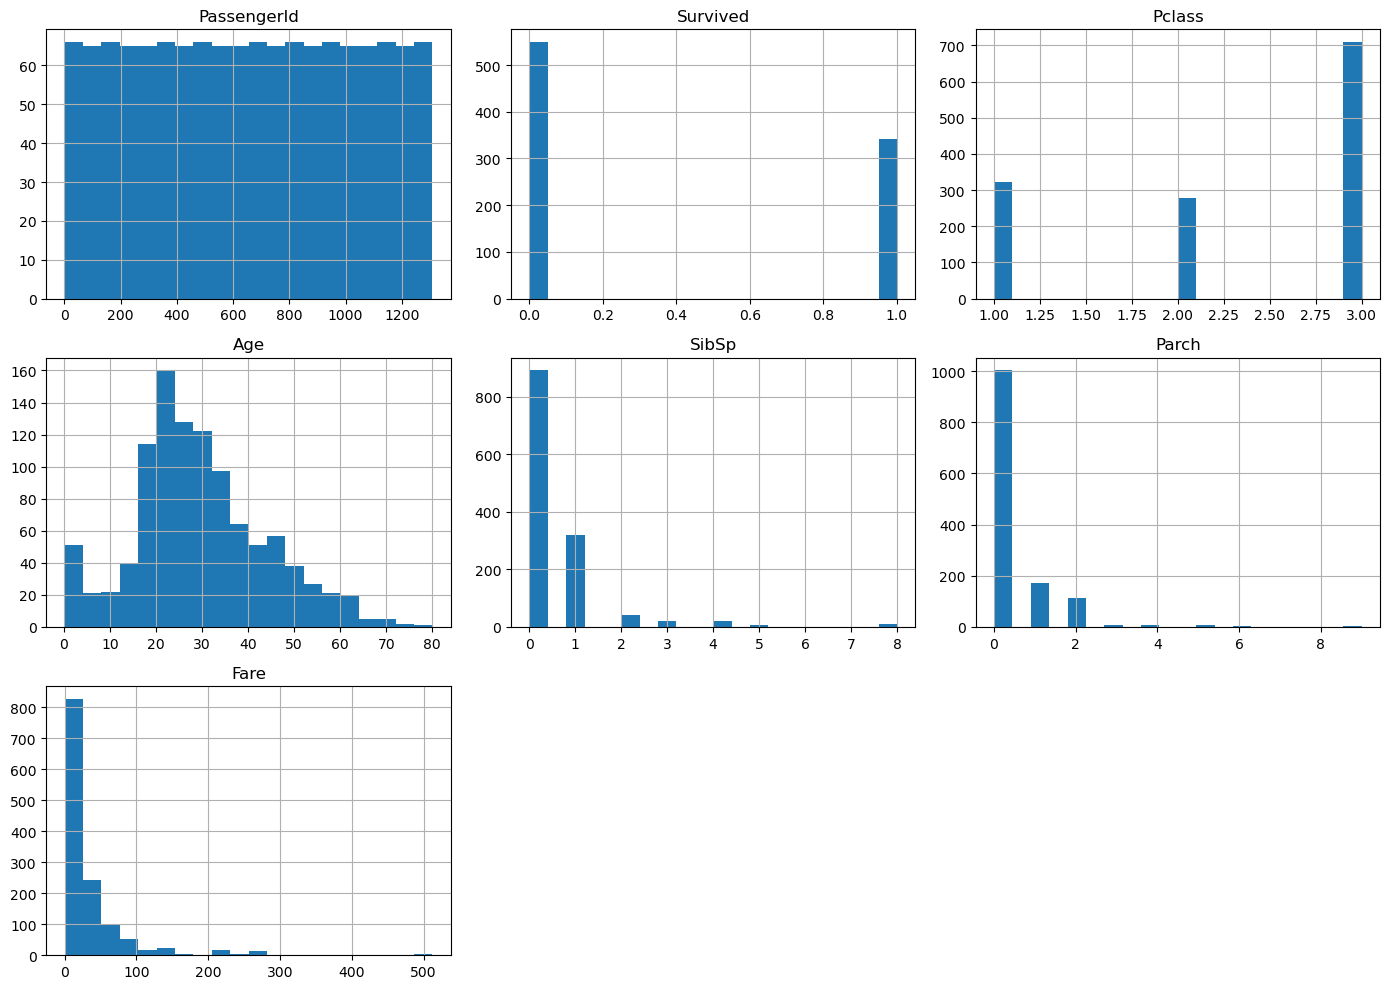

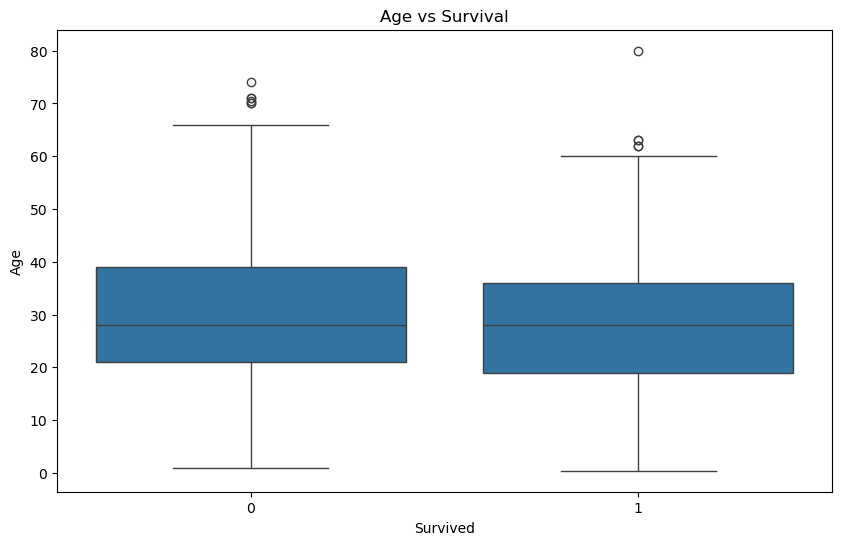

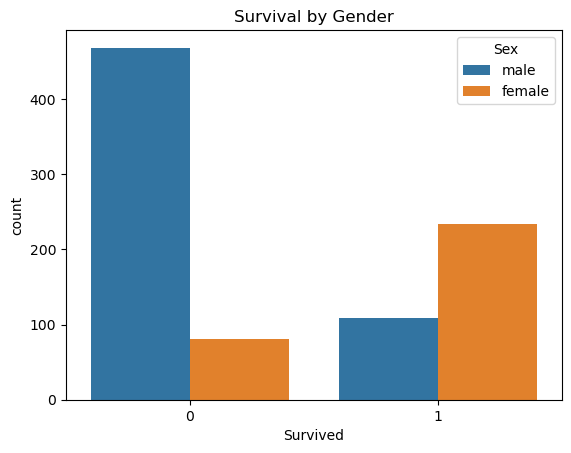

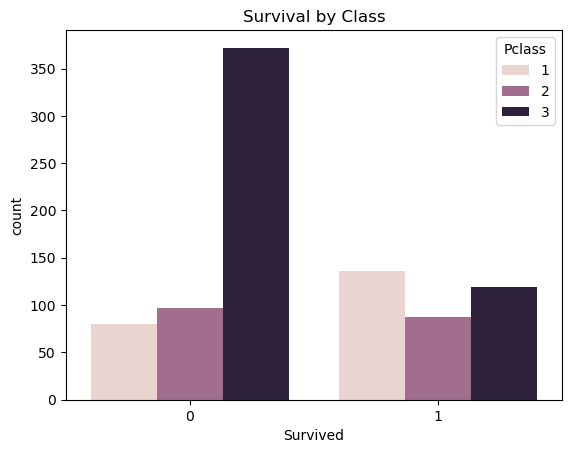

In [6]:
# 3. EXPLORATORY DATA ANALYSIS
print(data.info())
print(data.describe())

# Missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Histograms
data.hist(bins=20, figsize=(14, 10))
plt.tight_layout()
plt.show()

# Box plots
plt.figure(figsize=(10,6))
sns.boxplot(x='Survived', y='Age', data=train_df)
plt.title("Age vs Survival")
plt.show()

# Bar plots
sns.countplot(x='Survived', hue='Sex', data=train_df)
plt.title("Survival by Gender")
plt.show()

sns.countplot(x='Survived', hue='Pclass', data=train_df)
plt.title("Survival by Class")
plt.show()

In [10]:
# Fill missing Age values using median grouped by Pclass
data['Age'] = data.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# Fill missing Embarked with mode
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])

# Fill missing Fare with median
data['Fare'] = data['Fare'].fillna(data['Fare'].median())

# Drop irrelevant columns if they exist
data.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1, inplace=True, errors='ignore')

# Encode categorical variables
label = LabelEncoder()
data['Sex'] = label.fit_transform(data['Sex'])
data['Embarked'] = label.fit_transform(data['Embarked'])

# Split combined data back into train and test sets
train = data[:len(train_df)]
test = data[len(train_df):]


In [11]:
# 5. TRAIN-TEST SPLIT
X = train.drop('Survived', axis=1)
y = train['Survived']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# 6. MODELING

# LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_preds = lgb_model.predict(X_val)

# XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_val)

# 7. EVALUATION
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Performance:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

evaluate_model("LightGBM", y_val, lgb_preds)
evaluate_model("XGBoost", y_val, xgb_preds)

[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 194
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


C:\Users\sschp\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:40:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [17]:
from sklearn.model_selection import cross_val_score

# Re-initialize models with clean configs
lgb_model = lgb.LGBMClassifier(verbose=-1)
xgb_model = xgb.XGBClassifier(eval_metric='logloss')  # Removed deprecated use_label_encoder param

# Cross-validation with 5 folds
lgb_scores = cross_val_score(lgb_model, X, y, cv=5, scoring='accuracy')
xgb_scores = cross_val_score(xgb_model, X, y, cv=5, scoring='accuracy')

# Display average accuracy
print("Cross-Validated Accuracy (LightGBM):", round(lgb_scores.mean(), 4))
print("Cross-Validated Accuracy (XGBoost):", round(xgb_scores.mean(), 4))


Cross-Validated Accuracy (LightGBM): 0.8294
Cross-Validated Accuracy (XGBoost): 0.816


In [20]:
# 9. PREDICTION ON TEST DATA

# Re-train models on full training data
lgb_model.fit(X, y)
xgb_model.fit(X, y)

# Prepare test data (drop 'Survived' if present)
X_test = test.drop('Survived', axis=1, errors='ignore')

# Make predictions
test_predictions_lgb = lgb_model.predict(X_test)
test_predictions_xgb = xgb_model.predict(X_test)

# Optional: Save results to CSV
pd.DataFrame({'Survived': test_predictions_lgb}).to_csv("submission_lgb.csv", index=False)
pd.DataFrame({'Survived': test_predictions_xgb}).to_csv("submission_xgb.csv", index=False)

# Display first few predictions for verification
print("LightGBM Predictions (first 10):", test_predictions_lgb[:10])
print("XGBoost Predictions (first 10):", test_predictions_xgb[:10])


LightGBM Predictions (first 10): [0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
XGBoost Predictions (first 10): [0 0 0 0 0 0 0 0 1 0]
